# Сегментация пользователей мобильного приложения

У нас есть логи мобильного приложения. Задача: проанализировать логи и разделить пользователей на группы, исходя из того, как они пользуются приложением.

### Загрузка и предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math as mth

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split

In [2]:
sources = pd.read_csv(r'mobile_soures.csv')
dataset = pd.read_csv(r'mobile_dataset.csv')

In [3]:
sources.sample(10)

,userId,source
2094,3a81141c-dbe2-432c-bf75-464df97531ad,other
2149,d69a4922-306e-4d19-8826-2ed6cbe6388d,google
2956,865d6a4a-8366-4cd7-8f48-e40ccc7f4ff7,yandex
2386,758b2f1c-5495-4e6e-b34e-d0c2a54aeaaf,other
1656,a63a3178-f1e0-48e8-b1ff-d05ed2887198,other
758,f9fee255-7704-4d2c-9fe6-2ffe23157d13,yandex
846,1842daab-cf2f-4b7b-a8e1-9411c956ef2a,yandex
1381,cbb24aa2-80cf-4ae7-a119-3304443f66a0,yandex
3673,2ac0bf7e-964b-43cf-9fd7-a56c548c64dc,other
3513,6d0e0712-85b4-43de-b8d2-4048540a4e9d,other


In [4]:
dataset.sample(10)

,event.time,event.name,user.id
59836,2019-10-29 16:45:19.518675,tips_show,2df76bc0-b941-4ae9-9357-58244e885ab7
61805,2019-10-30 11:39:59.340396,tips_show,87b9b9a1-e7c1-4834-a43e-4510f177f3f9
61057,2019-10-29 23:12:40.802841,tips_show,570e1e48-5bfb-4c99-84b6-a10d9a15bf05
67201,2019-11-01 10:02:41.191706,tips_show,f2c745ca-e1bf-4ea9-af47-ce48224c484c
12354,2019-10-12 18:25:07.485206,tips_show,23cd3e07-d084-4c7d-8019-c57c268aff3b
44852,2019-10-24 16:07:20.120432,tips_show,a9a31e05-6a54-497b-b827-baff2ecd5a45
37841,2019-10-22 12:45:27.043877,tips_show,cdea846c-f331-4e00-beba-4837aa078f50
73974,2019-11-03 22:23:39.053345,tips_show,bd74ba4a-2531-4b4c-950a-84ea2bd7e0ac
16501,2019-10-14 11:40:51.352654,contacts_call,3da82b2a-1376-4dde-a29b-0d96d159f2d0
23477,2019-10-16 18:51:31.710275,photos_show,9f9034e9-966d-4052-b3ab-5389f9585eb3


In [5]:
display(dataset.info())
display(sources.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
event.time    74197 non-null object
event.name    74197 non-null object
user.id       74197 non-null object
dtypes: object(3)
memory usage: 1.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
userId    4293 non-null object
source    4293 non-null object
dtypes: object(2)
memory usage: 67.2+ KB


None

Пропусков и неправдоподобных значений не видно. Но из описания данных мы знаем, что по какой-то причине одно и то же действие в `dataset` проходит под двумя разными именами -- `show_contacts` и `contacts_show`. Это нужно исправить. Кроме того, переименуем для удобства столбцы, а столбец с датой и временем приведем к `datetime`.

In [6]:
dataset.rename(columns = {'event.time': 'event_time', 
                          'event.name': 'event_name', 
                          'user.id': 'user_id'}, inplace=True)
sources.rename(columns = {'userId': 'user_id'}, inplace=True)

dataset.event_time = pd.to_datetime(dataset.event_time)

dataset.loc[dataset['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'
dataset.event_name.unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

У нас есть 4293 уникальных пользователя и 15 типов действий/событий, которые они совершали в приложении. Посмотрим на данные подробнее.

In [7]:
display(dataset.describe())
display(sources.describe())

,event_time,event_name,user_id
count,74197,74197,74197
unique,74197,15,4293
top,2019-10-20 20:53:28.313292,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478
first,2019-10-07 00:00:00.431357,NaN,NaN
last,2019-11-03 23:58:12.532487,NaN,NaN


,user_id,source
count,4293,4293
unique,4293,3
top,4e06f0ff-7323-4047-bfb8-91f779a833b0,yandex
freq,1,1934


Стали ясны хронологические рамки исследования: с 7 октября по 3 ноября 2019 г., четыре полных недели. Проверим, насколько равномерно распределены данные в пределах этого периода. Для этого создадим столбец с датой и заодно -- с номером недели (пригодится для подсчета WAU).

In [8]:
dataset['event_date'] = dataset.event_time.dt.date
dataset['event_week'] = dataset.event_time.dt.week

c:\users\1\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


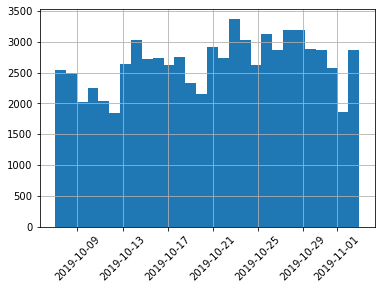

In [9]:
dataset.event_date.hist(bins=28, xrot=45)

Данные поступали достаточно равномерно.

Для удобства склеим два датафрейма по столбцу `user_id`.

In [10]:
df = dataset.merge(sources, on='user_id')
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 6 columns):
event_time    74197 non-null datetime64[ns]
event_name    74197 non-null object
user_id       74197 non-null object
event_date    74197 non-null object
event_week    74197 non-null int64
source        74197 non-null object
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 4.0+ MB


None

Убедимся, что ни в одном из исходных датафреймов не было `user_id`, которого не оказалось бы в другом датафрейме.

In [11]:
display(sources[~sources.user_id.isin(df.user_id)])
display(df[~df.user_id.isin(sources.user_id)])

,user_id,source


,event_time,event_name,user_id,event_date,event_week,source


Проверим сводные данные на выбросы по количеству действий в приложении на одного пользователя.

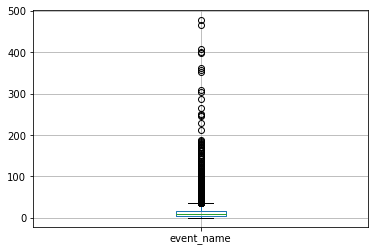

In [12]:
df.groupby('user_id')['event_name'].count().reset_index().boxplot()

Есть значительные выбросы. Найдем верхнюю границу нормы для количества действий на одного пользователя, исходя из критерия "75-я перцентиль плюс полтора межквартильных интервала".

In [13]:
def upper_limit(data):
    '''Эта функция определяет положение верхнего уса ящика с усами для поданного на вход датасета'''
    p_75 = data.describe()['75%']
    p_25 = data.describe()['25%']
    iqr = p_75 - p_25
    upper_whisker = p_75 + 1.5*iqr
    return upper_whisker

upper_limit(df.groupby('user_id')['event_name'].count())

35.0

Посмотрим, сколько уников и сколько строк исходного датасета мы потеряем, если исключим из рассмотрения аномально активных пользователей.

In [14]:
display(df.groupby('user_id')['event_name'].count().reset_index().shape[0] -\
        df.groupby('user_id')['event_name'].count().reset_index().query('event_name < 36').shape[0])
display(round(df.groupby('user_id')['event_name'].count().reset_index().query('event_name > 35').shape[0] /\
        df.groupby('user_id')['event_name'].count().reset_index().shape[0] * 100, 1))

434

10.1

In [15]:
too_active = df.groupby('user_id')['event_name'].count().reset_index().query('event_name > 35').user_id
display(df.shape[0] - df.loc[~df['user_id'].isin(too_active)].shape[0])
display(round(df.loc[df['user_id'].isin(too_active)].shape[0] / df.shape[0] * 100, 1))

33670

45.4

Больше 10% уников и 45% строк исходного датасета, это много. Если удалить эти строки, можно потерять важную информацию, связанную с другими параметрами. Поэтому исключим эти аномалиии из рассмотрения пока только при подсчете количества действий на одного пользователя, а совсем удалять не будем.

,event_name
count,3859.000000
mean,10.501944
std,7.351480
min,1.000000
25%,5.000000
50%,8.000000
75%,14.000000
max,35.000000


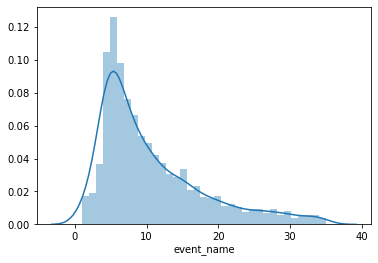

In [16]:
calm = df.groupby('user_id')['event_name'].count().reset_index().query('event_name < 36')
display(calm.describe())
sns.distplot(calm['event_name'], bins=35)

Распределение унимодальное, немного скошенное вправо. Медианное значение 8, среднее -- 10,5 действий на одного пользователя. Посмотрим, какие цифры получатся на неочищенных данных.

In [17]:
display(df.groupby('user_id')['event_name'].count().reset_index().describe())

,event_name
count,4293.000000
mean,17.283252
std,29.130677
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,478.000000


Разница в средних довольно велика, а медиана очень устойчива к выбросам -- разница всего в единицу.

Нет ли дубликатов?

In [18]:
df[df.duplicated()]

,event_time,event_name,user_id,event_date,event_week,source


Все в порядке. Можно приступать к анализу данных.

### Анализ данных



**Частота вхождения действий каждого типа и событийная воронка**

Чтобы понять, как выглядит событийная воронка приложения, посмотрим, как часто в датасете встречаются действия разных типов и как часто события разных типов совершают уникальные пользователи.

In [19]:
display(df.groupby('event_name')['user_id'].count().sort_values(ascending=False)) # частота событий
display(df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)) # частота событий по уникам

event_name
tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: user_id, dtype: int64

event_name
tips_show        2801
map              1456
photos_show      1095
contacts_show     981
search_1          787
advert_open       751
search_5          663
search_4          474
favorites_add     351
search_6          330
tips_click        322
search_2          242
contacts_call     213
search_3          208
search_7          157
Name: user_id, dtype: int64

Целевым действием воронки будем считать `contacts_show` (пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления). Следующее по логике действие -- `contacts_call` (пользователь позвонил по номеру телефона на карточке объявления) --  на некоторых платформах (десктоп/планшет) совершить технически невозможно, а поскольку в логах нет информации о платформах, то и достоверных данных о конверсии из `contacts_show` в `contacts_call` нам взять неоткуда.

Какое действие предшествует в воронке `contacts_show`? Проще всего было бы ответить на этот вопрос, изучив само приложение, но доступа к нему у нас нет, а анализ последовательности действий в пользовательских сессиях, которые будут выделены выше, займет слишком много времени. Судя по таблицам выше, пользователь может приходить к целевому действию разными путями, то есть кнопка "показать контакты" доступна не только изнутри карточки объявления, но и из списка рекомендованных объявлений, и из поисковой выдачи. Можно было бы принять за вход в воронку самое популярное событие -- показ рекомендованных объявлений (`tips_show`), на которое приходится более половины из 74 с лишним тысяч событий. Но его совершают не все уникальные пользователи, да и вообще непонятно, не совершается ли это событие помимо воли пользователя (допустим, в виде принудительного показа "карусели" при заходе на главный экран приложения). Так что за первую ступень воронки, относительно которой будем считать конверсию, примем просто количество уникальных пользователей приложения. 

Поисковые действия (`search_1` - `search_7`) можно будет объединить в поисковые стратегии и проверить на корреляцию с конверсией. Такую же проверку стоит провести и с `favorites_add` (добавление объявления в избранное).

Итак, посчитаем конверсию в `contacts_show` в зависимости от источника. Но прежде убедимся, что каждый уникальный пользователь в логах пользуется только одним источником.

In [20]:
other_users = df.query('source == "other"').user_id.unique()
google_users = df.query('source == "google"').user_id.unique()
yandex_users = df.query('source == "yandex"').user_id.unique()

display(pd.Series(other_users).isin(google_users).unique())
display(pd.Series(other_users).isin(yandex_users).unique())
display(pd.Series(google_users).isin(other_users).unique())
display(pd.Series(google_users).isin(yandex_users).unique())
display(pd.Series(yandex_users).isin(google_users).unique())
display(pd.Series(yandex_users).isin(other_users).unique())

array([False])

array([False])

array([False])

array([False])

array([False])

array([False])

In [21]:
users_by_source = df.groupby('source')['user_id'].nunique().reset_index()
users_by_source.rename(columns={'user_id': 'users_total'}, inplace=True)
target_users_by_source = df.query('event_name == "contacts_show"').groupby('source')['user_id'].nunique().reset_index()
target_users_by_source.rename(columns={'user_id': 'users_target'}, inplace=True)
funnel = users_by_source.merge(target_users_by_source, on='source')
funnel['pct'] =  round(funnel.users_target / funnel.users_total * 100, 3)
funnel

,source,users_total,users_target,pct
0,google,1129,275,24.358
1,other,1230,228,18.537
2,yandex,1934,478,24.716


Предварительно можно сказать, что оба поисковика дают примерно одинаковую конверсию, а остальные источники им заметно уступают. Небольшая разница между Google и Yandex все-таки есть -- ниже проверим, значима ли она статистически.

**DAU и WAU**

В нашем распоряжении есть данные за месяц, так что можно посчитать, сколько пользователей в среднем пользуются приложением в день (DAU) и неделю (WAU). Для сегментации это не нужно, но эти цифры все равно могут быть интересны заказчику исследования -- продуктовому менеджеру.

In [22]:
daily_audience = df.groupby('event_date')['user_id'].nunique()
weekly_audience = df.groupby('event_week')['user_id'].nunique()

display(df.groupby('event_date')['user_id'].nunique().describe())
display(df.groupby('event_week')['user_id'].nunique().describe())

count     28.000000
mean     279.178571
std       46.737291
min      178.000000
25%      238.250000
50%      292.500000
75%      310.500000
max      352.000000
Name: user_id, dtype: float64

count       4.000000
mean     1382.500000
std       177.661663
min      1130.000000
25%      1344.500000
50%      1427.000000
75%      1465.000000
max      1546.000000
Name: user_id, dtype: float64

В среднем ~280 пользователей в день и ~1380 в неделю. Средние значения несильно отличаются от медианных. Посмотрим динамику во времени.

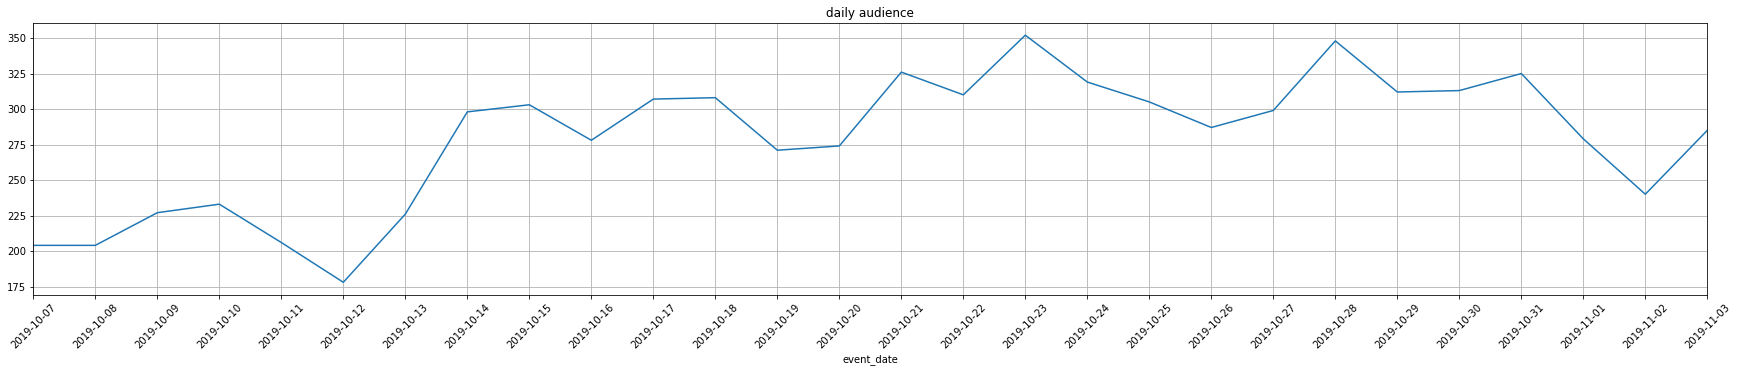

In [23]:
daily_audience.plot(figsize=(30,5), xticks=df.event_date.unique(), grid=True, rot=45, title='daily audience')

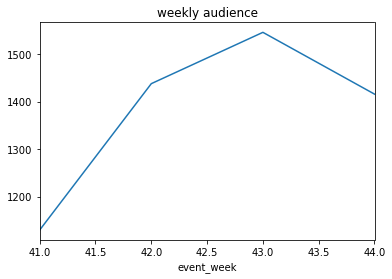

In [24]:
weekly_audience.plot(title='weekly audience')

Недельных циклов не видно. Оба графика показывают, что в конце первой недели наметился рост, который на третьей неделе достиг кульминации и сменился незначительным спадом.

**Частота совершения действий в приложении**

Сколько действий совершает каждый из пользователей отдельно и все они вместе за день/неделю? А за все время наблюдений? Чтобы ответить на эти вопросы, нужно узнать, какую часть наблюдаемого периода человек пользовался приложением, и разделить на это число количество совершенных им действий. Цифры за неделю получим умножением дневных данных на 7. Затем найдем медианные значения по всему датасету.

In [25]:
user_freq = (df.event_time.max() - df.groupby('user_id')['event_time'].min()).reset_index()
user_freq.rename(columns={'event_time': 'days_active'}, inplace=True)
user_freq.days_active = user_freq.days_active / np.timedelta64(1, 'D')
user_freq['events_total'] = df.groupby('user_id')['event_name'].count().reset_index().event_name
user_freq['events_per_day'] = user_freq.events_total / user_freq.days_active
user_freq['events_per_week'] = user_freq.events_per_day * 7

print('Медианное количество действий в приложении на пользователя в день: {}'
      .format(round(user_freq.events_per_day.median(), 2)))
print('Медианное количество действий в приложении на пользователя в неделю: {}'
      .format(round(user_freq.events_per_week.median(), 2)))

Медианное количество действий в приложении на пользователя в день: 0.77
Медианное количество действий в приложении на пользователя в неделю: 5.4


Теперь добавим в `user_freq` данне о частоте совершения действий каждого типа для каждого пользователя. Медианы искать не будем, т.к. на роль метрик эти данные не годятся, а для сегментации пользователей они тоже не нужны.

In [26]:
event_freq = df.pivot_table('event_time', 'user_id', 'event_name', aggfunc='count').fillna(0)
all_freq = user_freq.merge(event_freq, on='user_id')
all_freq_weighted = all_freq.copy()
for col in all_freq_weighted.loc[:, 'advert_open':'tips_show'].columns:
    all_freq_weighted[col] = all_freq_weighted[col] / all_freq_weighted.days_active

all_freq_weighted

,user_id,days_active,events_total,events_per_day,events_per_week,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,27.429474,35,1.276000,8.931998,0.000000,0.000000,0.000000,0.000000,0.218743,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.057257
1,00157779-810c-4498-9e05-a1e9e3cedf93,15.099753,71,4.702064,32.914445,0.132452,0.331131,0.728489,0.132452,0.000000,2.185466,1.192072,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,00463033-5717-4bf1-91b4-09183923b9df,2.419180,10,4.133632,28.935425,0.000000,0.000000,0.000000,0.000000,0.000000,4.133632,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,16.072303,32,1.991003,13.937019,0.311094,0.000000,0.000000,0.000000,0.373313,0.000000,0.000000,0.0,0.062219,0.124438,0.373313,0.124438,0.373313,0.0,0.248875
4,00551e79-152e-4441-9cf7-565d7eb04090,9.301056,8,0.860117,6.020821,0.000000,0.322544,0.322544,0.000000,0.000000,0.107515,0.107515,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,21.324133,17,0.797219,5.580532,0.000000,0.000000,0.000000,0.000000,0.093790,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.703428
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,27.142622,7,0.257897,1.805279,0.000000,0.000000,0.036842,0.000000,0.000000,0.221055,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4290,ffcf50d9-293c-4254-8243-4890b030b238,11.504599,2,0.173844,1.216905,0.000000,0.000000,0.000000,0.000000,0.086922,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.086922
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,13.304614,13,0.977105,6.839732,0.000000,0.000000,0.075162,0.000000,0.000000,0.526133,0.375809,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


**Анализ пользовательских сессий**

Для дальнейшего анализа нам нужно выделить пользовательские сессии. Применим самый простой подход, построенный на периоде неактивности: если между двумя действиями одного и того же пользователя прошло больше какого-то количества времени, будем считать, что эти два действия относятся к разным сессиям.

Сначала сгруппируем датафрейм по `user_id` и для каждого действия посчитаем время, прошедшее с предшествующего действия, а потом в отдельном столбце округлим эти значения до минуты.

In [27]:
df['time_lag'] = df.sort_values(by='event_time').groupby('user_id')['event_time'].diff().fillna(0)
df['time_lag_minutes'] = df.time_lag.apply(lambda x: round(x.seconds / 60))

<ipython-input-27-8eafd14451e9>:1: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  df['time_lag'] = df.sort_values(by='event_time').groupby('user_id')['event_time'].diff().fillna(0)


В новом столбце у нас фактически вперемежку записаны (1) периоды между соседними действиями в рамках одной сессии и (2) периоды между сессиями, и нам как-то нужно отделить одно от другого. Логично предположить, что у стандартного пользователя периодов первого типа больше, чем второго, ведь в продуктовой воронке нашего приложения точно больше двух действий, а значит в стандартной сессии как минимум два промежутка между действиями, тогда как между сессиями промежуток всегда один. Таким образом, нужно отсеять самые частотные значения в этом столбце, а оставить самые редкие -- это и будут периодами между сессиями.

Для каждого пользователя посчитаем верхнюю границу нормальной длительности периода между двумя действиями с помощью функции `upper_limit()`. Затем найдем медианное значение по всем пользователям и любой более длительный промежуток будем считать перерывом между двумя сессиями.

In [28]:
upper_limit(df.groupby('user_id')['time_lag_minutes']).median()

5.0

В рамках одной сессии действия пользователей редко отстоят друг от друга более чем на 5 минут.

Напишем функцию, которая пронумерует сессии каждого пользователя.

In [29]:
def session(data):
    sid_list = list()
    counter = 0
    for i in data['time_lag_minutes']:
        if i < 6:
            sid_list.append(counter)
        else:
            counter += 1
            sid_list.append(counter)
    data['session_id'] = sid_list
    return data

df = df.groupby('user_id').apply(session).reset_index()

Теперь можно рассчитать длительность каждой сессии, среднюю длительность сессий для каждого пользователя и -- на всякий случай -- медианную длительность всех сессий в наборе данных.

In [30]:
session_length = (df.groupby(['user_id', 'session_id'])['event_time'].max() - \
df.groupby(['user_id', 'session_id'])['event_time'].min()).reset_index()
session_length.rename(columns={'event_time': 'session_length'}, inplace=True)
session_length.session_length = session_length.session_length / np.timedelta64(1, 's')
freqs = all_freq_weighted.merge(session_length.groupby('user_id')['session_length'].mean().reset_index(), on='user_id')

print('Медианная длительность сессии в приложении: {} минута {} секунда'
      .format(pd.to_datetime(session_length.session_length.median(), unit='s').minute,
              pd.to_datetime(session_length.session_length.median(), unit='s').second))

Медианная длительность сессии в приложении: 1 минута 51 секунда


Узнаем, сколько сессий в день приходится на каждого пользователя.

In [31]:
num_sessions = df.groupby('user_id')['session_id'].nunique().reset_index().rename(columns={'session_id': 'sessions_total'})
freqs = freqs.merge(num_sessions, on='user_id')
freqs['sessions_per_day'] = freqs.sessions_total / freqs.days_active 

И сколько действий в среднем приходится на сессию у каждого пользователя.

In [32]:
freqs['events_per_session'] = freqs.events_per_day / freqs.sessions_per_day

In [33]:
print('Медианное количество действий в усредненной пользовательской сессии: {}'\
      .format(freqs.events_per_session.median()))
print('Медианное количество сессий в день на пользователя: {}'\
      .format(freqs.sessions_total.median()))

Медианное количество действий в усредненной пользовательской сессии: 4.0
Медианное количество сессий в день на пользователя: 2.0


**Поисковые стратегии**

В разделе с тестированием гипотез проверим, коррелируют ли поисковые стратегии пользователей приложения с конверсией в `contacts_show`. Для этогого выберем всех пользователей, которые пользуются поисковыми функциями приложения (`search_1...7`).

Преобразование типов во второй строке нужно для того, чтобы сделать каждую ячейку столбца `event_name` хешируемой. Используется `frozenset()`, а не `tuple()`, чтобы отсеять  перестановки. В принципе можно изучать и их (вдруг порядок тоже влияет на конверсию?), но у нас для этого маловато данных.

In [34]:
searchers = df.query('event_name.str.contains("search")').groupby('user_id')['event_name'].unique().reset_index()
searchers.event_name = searchers.event_name.apply(lambda x: frozenset(x.tolist()))
search_patterns = searchers.groupby('event_name')['user_id'].unique().reset_index()
search_patterns = search_patterns.explode('user_id')
search_patterns.rename(columns={'event_name': 'search_pattern'}, inplace=True)
search_patterns['inquiry_types'] = search_patterns.search_pattern.apply(lambda x: len(list(x)))
search_patterns

,search_pattern,user_id,inquiry_types
0,(search_1),00157779-810c-4498-9e05-a1e9e3cedf93,1
0,(search_1),00551e79-152e-4441-9cf7-565d7eb04090,1
0,(search_1),00753c79-ea81-4456-acd0-a47a23ca2fb9,1
0,(search_1),00a93a72-3bbc-4ee7-8a81-7134f45ae009,1
0,(search_1),00af35c4-2045-4960-96b8-7fd5f1978a88,1
...,...,...,...
51,"(search_7, search_5, search_4, search_6)",c7917c09-e536-4998-a92d-4fac8644ea3a,4
51,"(search_7, search_5, search_4, search_6)",c81944b3-3642-4c5d-8408-9e401263cc53,4
51,"(search_7, search_5, search_4, search_6)",dfd5756c-255d-46ec-a443-fbc4a9784d64,4
52,"(search_5, search_4, search_7, search_2, searc...",19e5f9eb-fe31-44de-8351-d32e977e731c,6


Получился список всех пользователей, которые пользуются поиском в приложении (таких 1666 или чуть менее 38% уникальных пользователей), с указанием тех поисковых действий, которые они выполняли хотя бы по 1 разу, и количества действий в "наборе" каждого. Соединим его с таблицей, в которой у нас собраны данные о пользователях.

In [35]:
freqs_final = freqs.merge(search_patterns, how='left', left_on='user_id', right_on='user_id')
freqs_final.inquiry_types = freqs_final.inquiry_types.fillna(0)
freqs_final.search_pattern = freqs_final.search_pattern.fillna('no_search')
freqs_final.head()

,user_id,days_active,events_total,events_per_day,events_per_week,advert_open,contacts_call,contacts_show,favorites_add,map,...,search_6,search_7,tips_click,tips_show,session_length,sessions_total,sessions_per_day,events_per_session,search_pattern,inquiry_types
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,27.429474,35,1.276000,8.931998,0.000000,0.000000,0.000000,0.000000,0.218743,...,0.000000,0.000000,0.0,1.057257,690.139277,4,0.145829,8.750000,no_search,0.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,15.099753,71,4.702064,32.914445,0.132452,0.331131,0.728489,0.132452,0.000000,...,0.000000,0.000000,0.0,0.000000,242.242665,17,1.125846,4.176471,(search_1),1.0
2,00463033-5717-4bf1-91b4-09183923b9df,2.419180,10,4.133632,28.935425,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,471.768980,2,0.826726,5.000000,no_search,0.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,16.072303,32,1.991003,13.937019,0.311094,0.000000,0.000000,0.000000,0.373313,...,0.124438,0.373313,0.0,0.248875,67.274496,13,0.808845,2.461538,"(search_4, search_5, search_7, search_6, searc...",5.0
4,00551e79-152e-4441-9cf7-565d7eb04090,9.301056,8,0.860117,6.020821,0.000000,0.322544,0.322544,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,42.955115,4,0.430059,2.000000,(search_1),1.0


**Таблица корреляций**

Построим тепловую карту корреляций, чтобы в первом приближении понять, какие параметры могут быть связаны, во-первых, с целевым параметром (`contacts_show`) и, во-вторых, между собой.

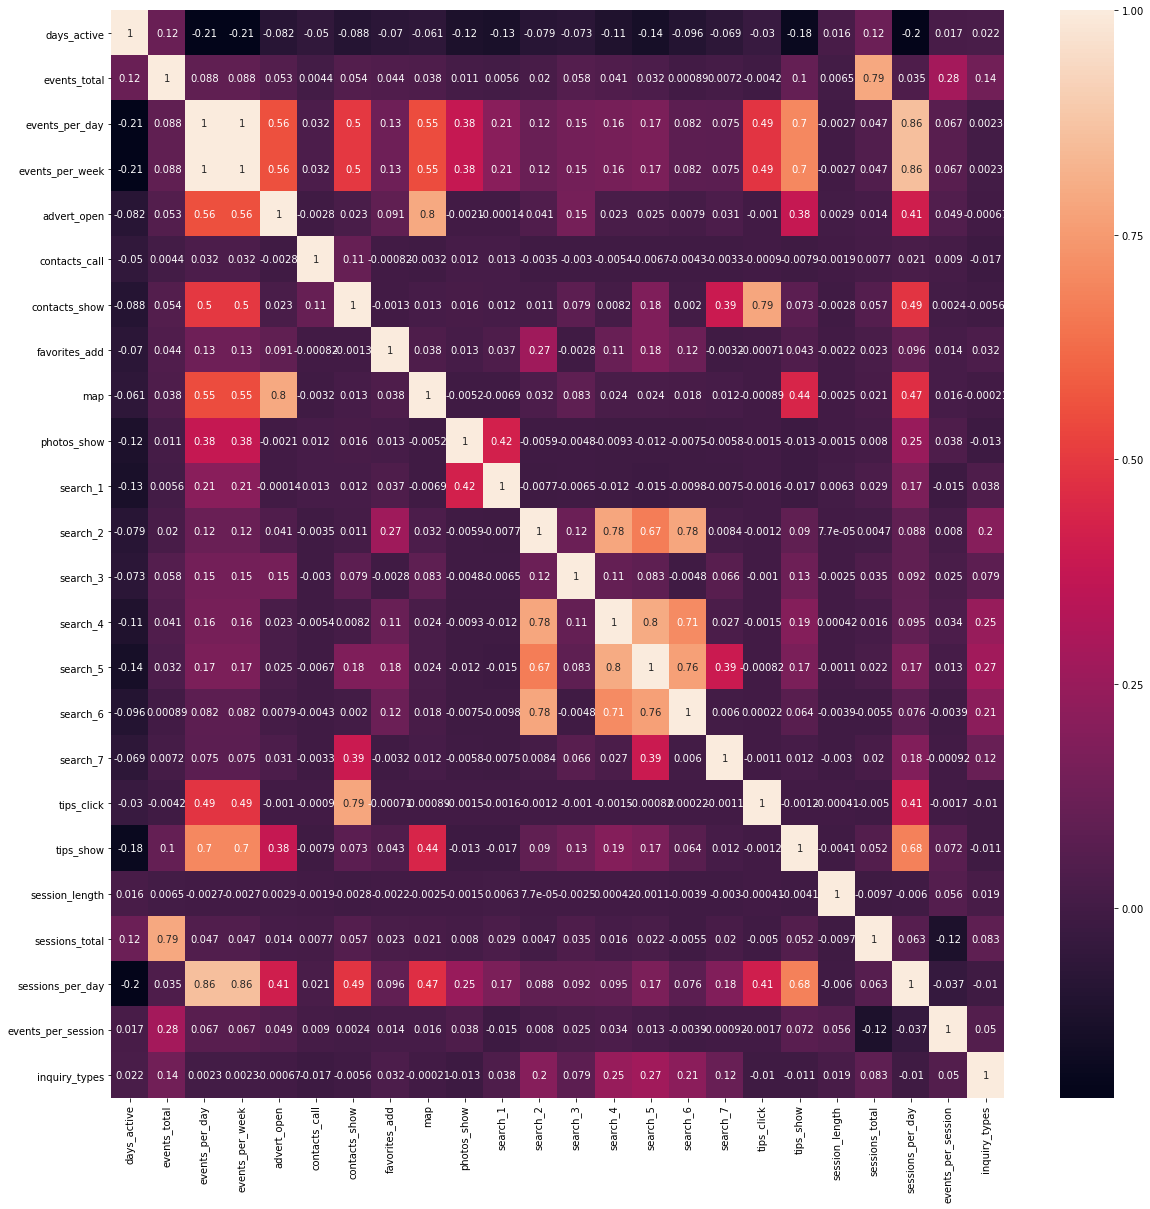

In [36]:
corr = freqs_final.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

Сильной отрицательной связи не видно. Зато есть несколько интересных случаев положительной корреляции: 
* `advert_open` (открытие карточки объявления) сильно (0,8) коррелирует с`map` (пользователь открыл карту размещенных объявлений)
* `contacts_show` почти так же сильно (0,79) коррелирует с `tips_click` (пользователь кликнул по рекомендованному объявлению)
* имеется также положительная корреляция (0,39) между `contacts_show` и одним из видов поиска, `search_7`
* поисковые действия `search_2` и `search_4...6` сильно коррелируют друг с другом (коэффициент Пирсона ~0,7-0,8, светлый сгусток в центре карты)
* добавление объявления в избранное не имеет значимой связи ни с одним из параметров.

Параметр `search_pattern` -- категориальный, так что его проверим при помощи группировки.

In [37]:
contacts_showers = pd.DataFrame(df.query('event_name == "contacts_show"').user_id.unique(), columns=['user_id'])
contacts_showers['target'] = pd.Series()
contacts_showers.target = contacts_showers.target.fillna(1)
freqs_ultimate = freqs_final.merge(contacts_showers[['user_id', 'target']], 
                                   how='left', 
                                   left_on='user_id', 
                                   right_on='user_id')
freqs_ultimate.target = freqs_ultimate.target.fillna(0) # потребуется для кластеризации
sorted_patterns = freqs_ultimate.groupby('search_pattern').agg({'target': 'sum', 'user_id': 'nunique'})\
.sort_values(by='user_id', ascending=False)
sorted_patterns.head(15)

,target,user_id
search_pattern,,
no_search,604.0,2627
(search_1),233.0,779
(search_3),17.0,138
"(search_5, search_4)",16.0,109
"(search_5, search_4, search_6)",13.0,92
"(search_5, search_2, search_4, search_6)",19.0,87
"(search_5, search_6)",7.0,74
"(search_5, search_4, search_2)",10.0,58
"(search_7, search_5)",9.0,54


Даже без учета перестановок видим всего 10 поисковых стратегий, каждой из которых пользуется более 30 пользователей (от 35 до 779), плюс самая многочисленная категория пользователей, которые вообще не пользуются поиском (тоже своего рода поисковая стратегия). Остальные принимать в расчет не будем как слишком малочисленные.

In [38]:
sorted_patterns = sorted_patterns.head(11)
sorted_patterns['conversion'] = round(sorted_patterns.target / sorted_patterns.user_id * 100, 2)
sorted_patterns.sort_values(by='conversion', ascending=False)

,target,user_id,conversion
search_pattern,,,
(search_1),233.0,779,29.91
no_search,604.0,2627,22.99
"(search_5, search_2, search_4, search_6)",19.0,87,21.84
"(search_5, search_4, search_2)",10.0,58,17.24
(search_4),6.0,35,17.14
"(search_7, search_5)",9.0,54,16.67
(search_5),6.0,40,15.00
"(search_5, search_4)",16.0,109,14.68
"(search_5, search_4, search_6)",13.0,92,14.13


Самая высокая конверсия в `contacts_show` (почти 30%) у пользователей, которые использовали `search_1` (и только его). Можно предположить, что `search_1` -- это поиск по тексту объявлений. Примечательно, что он, во-первых, редко сочетается с другими видами поиска и, во-вторых, не показал корреляции с `contacts_show`.

Те, кто поиском в приложении не пользовались вообще, немного отстают (~23%). 

С небольшим отрывом за ними следуют те, кто сочетает четыре вида поиска -- `search_2`, `search_4...6` (те самые, у которых высокая корреляция друг с другом). 

Интересно было бы оценить показатели конверсии среди пользователей, которые пользуются только `search_7`, который показал положительную связь с `show_contacts`, но этот вид поиска, к сожалению, недостаточно популярен.

**Кластеризация**

Для определения числа кластеров, которые мы передадим модели K-means, используем иерархическую кластеризацию. Передадим этому механизму в качестве целевого признака столбец `target` из `freqs_ultimate`, в котором для каждого пользователя указано, совершал ли он хотя бы раз действие `contacts_show` (1, если совершал, 0, если нет). Признаками будут данные из всех остальных колонок, соответствующих другим действиям в приложении, взвешенным по времени.

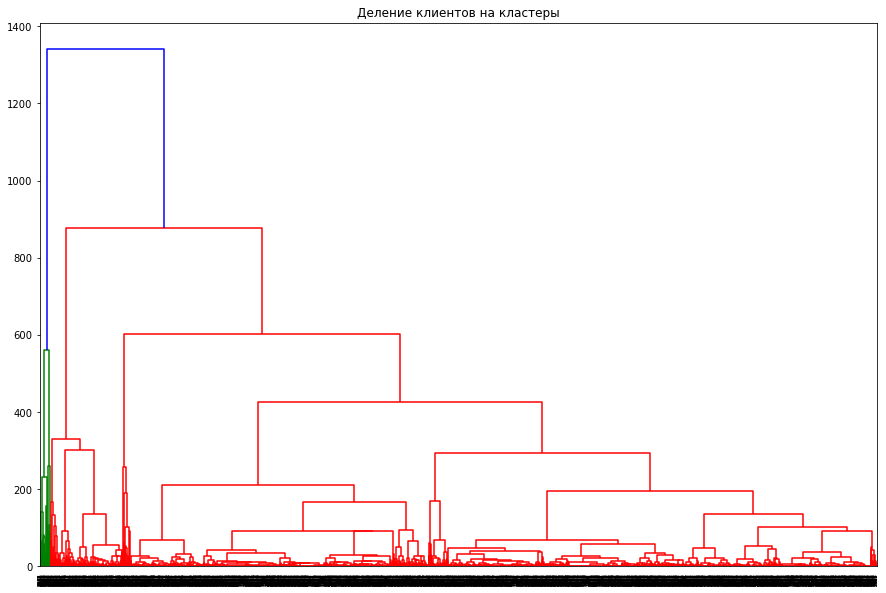

In [39]:
training_set = all_freq.merge(session_length.groupby('user_id')['session_length'].mean().reset_index(), on='user_id')
training_set = training_set.merge(num_sessions, on='user_id')
set_final = training_set.merge(search_patterns, how='left', left_on='user_id', right_on='user_id')
set_ultimate = set_final.merge(contacts_showers[['user_id', 'target']], 
                                   how='left', 
                                   left_on='user_id', 
                                   right_on='user_id')
set_ultimate.target = set_ultimate.target.fillna(0)

features = set_ultimate[['advert_open', 'favorites_add', 'map', 'photos_show', 'search_1', 'search_2',
       'search_3', 'search_4', 'search_5', 'search_6', 'search_7', 'tips_click', 'tips_show']]
target = set_ultimate['target']

# стандартизация данных
scaler = StandardScaler()
features_stadartized = scaler.fit_transform(features)

# построение таблицы связок между объектами
features_linked = linkage(features, method = 'ward')

# построение дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(features_linked, orientation='top')
plt.title('Деление клиентов на кластеры')
plt.show()

На дендрограмме видны два кластера, причем один многократно превышает по размерам второй. Передадим этот параметр в K-Means.

In [40]:
km = KMeans(n_clusters=2, random_state=954)
labels = km.fit_predict(features_stadartized)

freqs_ultimate['cluster_km'] = labels

ultimate_grouped = freqs_ultimate.groupby('cluster_km')[list(freqs_ultimate.drop('cluster_km', axis=1).columns)].mean()
display(ultimate_grouped)
display(freqs_ultimate.groupby('cluster_km')['user_id'].nunique())

,days_active,events_total,events_per_day,events_per_week,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,...,search_6,search_7,tips_click,tips_show,session_length,sessions_total,sessions_per_day,events_per_session,inquiry_types,target
cluster_km,,,,,,,,,,,,,,,,,,,,,
0,14.578918,14.841816,3.207193,22.450354,0.283129,0.019363,0.175960,0.054457,0.116924,0.607496,...,0.015388,0.007105,0.138198,1.566331,1405.979377,3.283632,0.731888,5.808406,0.605974,0.223656
1,18.071269,111.888889,9.496280,66.473962,1.574660,0.000000,0.551452,0.660071,0.534651,0.100663,...,0.127987,0.042326,0.051205,4.923382,723.299439,17.685185,1.341271,9.809822,3.009259,0.416667


cluster_km
0    4185
1     108
Name: user_id, dtype: int64

Алгоритм выделил около сотни самых активных пользователей -- закономерно, что они совершают больше целевых действий `contacts_show`, чем все остальные, так как они в принципе совершают больше действий. 

Интересно, что они никогда не звонят по номеру телефона в объявлении из приложения, только смотрят этот номер. Кроме того, они в среднем смотрят меньше фотографий, чем основная масса пользователей, и у них как правило короче сессия (легкую отрицательную корреляцию `contacts_show` с `session_length` можно видеть и на дендрограмме).

В самом начале, на этапе предобрабтки данных, мы заметили выбросы по количеству действий на пользователя. Оказалось, что условно нормальное значение этого параметра -- не более 35. Что будет, если еще раз запустить оба алгоритма на очищенных данных?

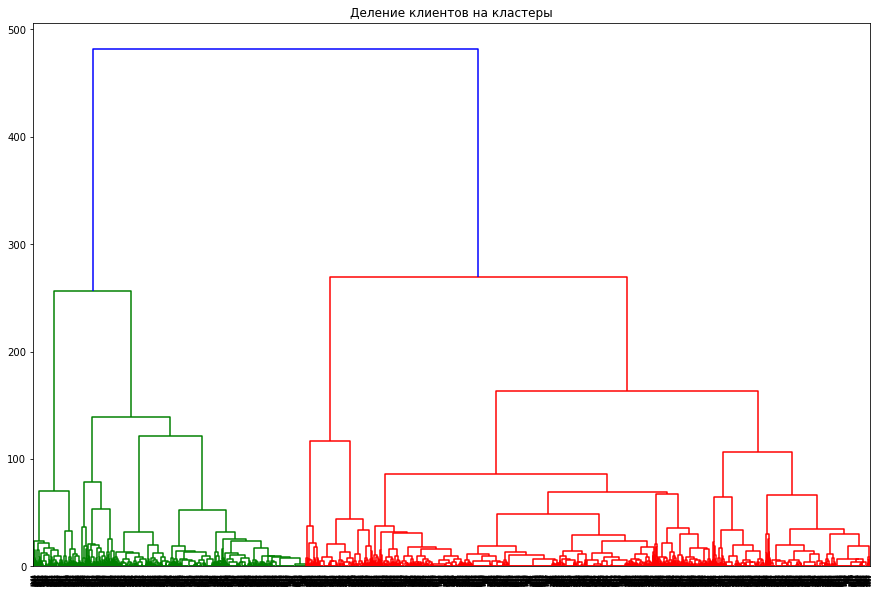

In [41]:
set_refined = set_ultimate.query('events_total < 36')

features = set_refined[['advert_open', 'favorites_add', 'map', 'photos_show', 'search_1', 'search_2',
       'search_3', 'search_4', 'search_5', 'search_6', 'search_7', 'tips_click', 'tips_show']]
target = set_refined['target']

scaler = StandardScaler()
features_stadartized = scaler.fit_transform(features)

features_linked = linkage(features, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(features_linked, orientation='top')
plt.title('Деление клиентов на кластеры')
plt.show()

In [42]:
km = KMeans(n_clusters=2, random_state=954)
labels = km.fit_predict(features_stadartized)

set_refined['cluster_km'] = labels

refined_grouped = set_refined.groupby('cluster_km')[list(set_refined.drop('cluster_km', axis=1).columns)].mean()
display(ultimate_grouped)
display(set_refined.groupby('cluster_km')['user_id'].nunique())

<ipython-input-42-0d13013eb6d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_refined['cluster_km'] = labels


,days_active,events_total,events_per_day,events_per_week,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,...,search_6,search_7,tips_click,tips_show,session_length,sessions_total,sessions_per_day,events_per_session,inquiry_types,target
cluster_km,,,,,,,,,,,,,,,,,,,,,
0,14.578918,14.841816,3.207193,22.450354,0.283129,0.019363,0.175960,0.054457,0.116924,0.607496,...,0.015388,0.007105,0.138198,1.566331,1405.979377,3.283632,0.731888,5.808406,0.605974,0.223656
1,18.071269,111.888889,9.496280,66.473962,1.574660,0.000000,0.551452,0.660071,0.534651,0.100663,...,0.127987,0.042326,0.051205,4.923382,723.299439,17.685185,1.341271,9.809822,3.009259,0.416667


cluster_km
0     493
1    3366
Name: user_id, dtype: int64

Все наблюдения, сделанные на неочищенных данных, справедливы и здесь, хотя разница в параметрах несколько сгладилась.

**Как часто пользователи возвращаются**

Нам доступны логи всего за месяц. На таком небольшом промежутке можно говорить о retention rate только для приложений, которые предполагают ежедневное или хотя бы еженедельное использование. Мы не знаем, с каким приложением имеем дело, но будем исходить из того, что оно отвечает названным условиям.

Создадим функцию, которая считает retention rate по дням, для начала передадим ей датафрейм `df` -- результат слияния данных из двух логов.

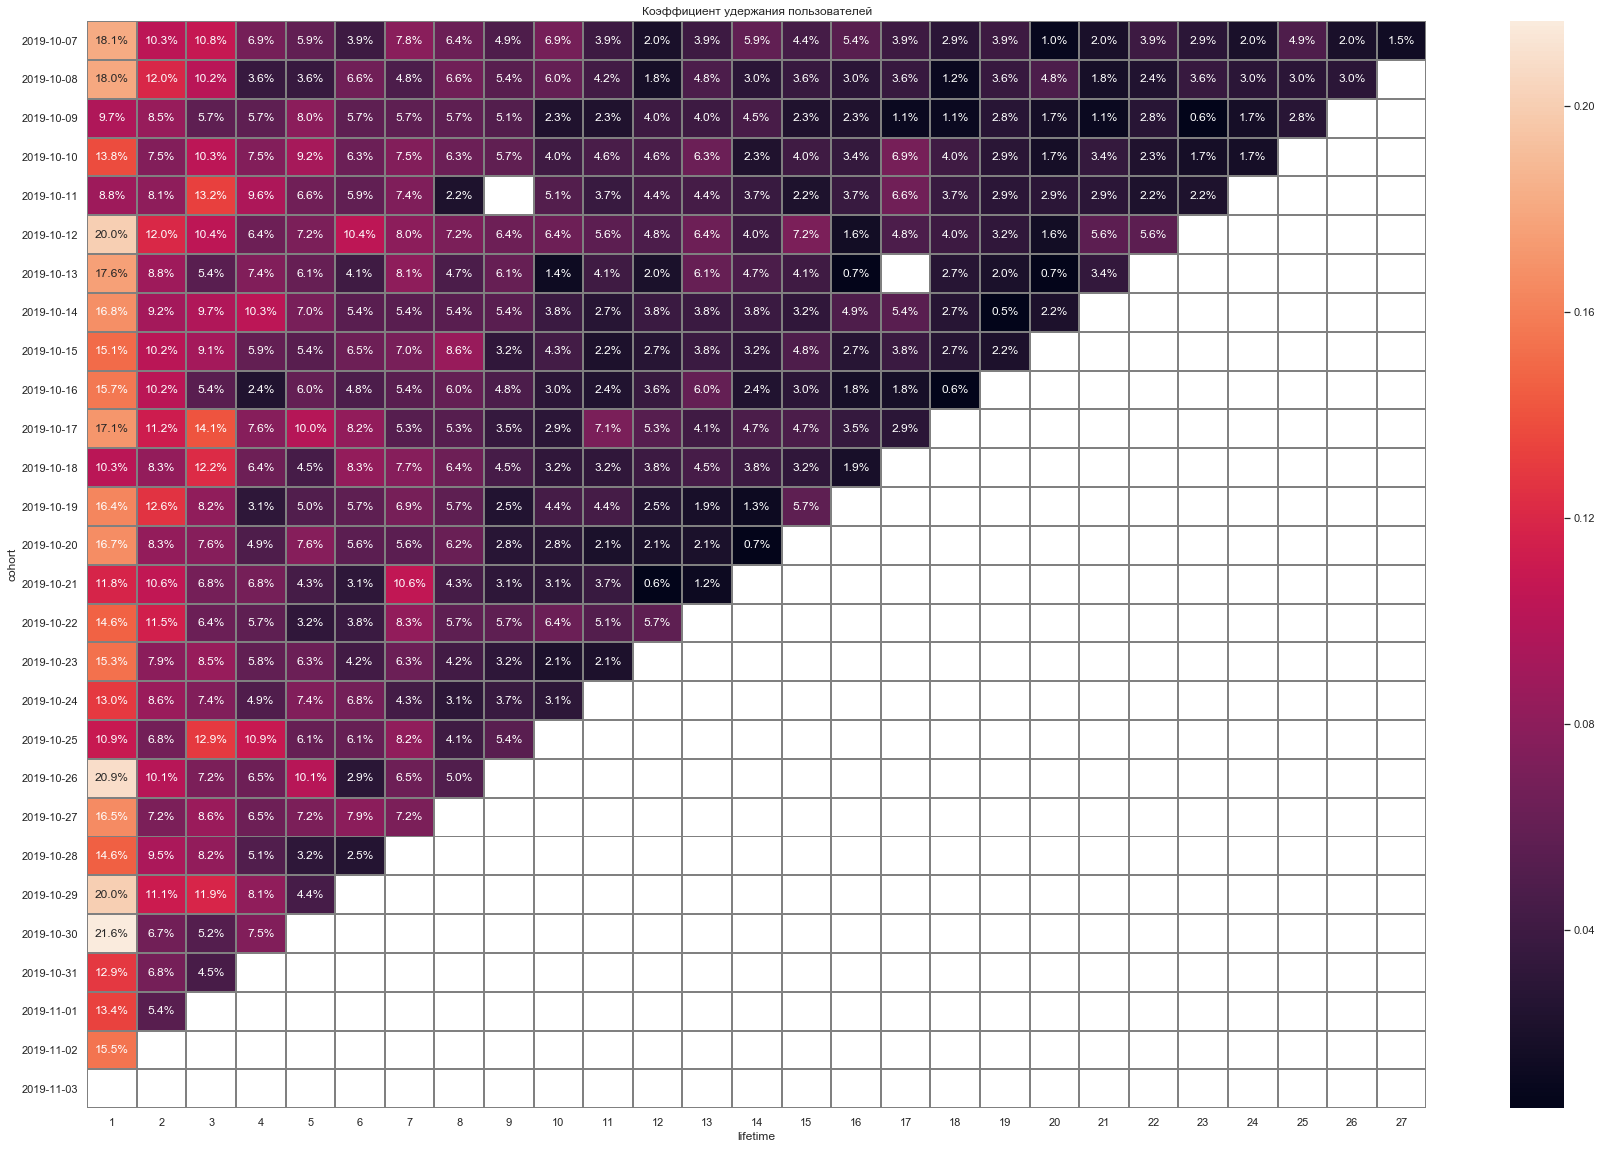

In [43]:
def show_retention(df):
    cohorts = df.groupby('user_id').agg({'event_time': 'min'}).reset_index()
    cohorts['cohort'] = cohorts.event_time.dt.to_period('D')
    cohorts.drop('event_time', axis=1, inplace=True)
    cohorts = cohorts.merge(df[['user_id', 'event_date']], on='user_id')
    cohorts['period'] = pd.to_datetime(cohorts.event_date).dt.to_period('D')
    cohorts['lifetime'] = (cohorts.period - cohorts.cohort).apply(lambda x: x.n) # чтобы получить частное в виде int

    initial_users_count = cohorts.query('lifetime == 0').groupby('cohort')['user_id'].nunique().reset_index()
    initial_users_count.rename(columns={'user_id': 'cohort_users'}, inplace=True)

    cohorts_grouped = cohorts.groupby(['cohort', 'lifetime'])['user_id'].nunique().reset_index()
    cohorts_grouped = cohorts_grouped.merge(initial_users_count, on='cohort')
    cohorts_grouped['retention'] = cohorts_grouped.user_id / cohorts_grouped.cohort_users
    retention_pivot = cohorts_grouped.pivot_table(
        index='cohort', 
        columns='lifetime', 
        values='retention', 
        aggfunc='sum')

    sns.set(style='white')
    plt.figure(figsize=(30,20))
    plt.title('Коэффициент удержания пользователей')
    sns.heatmap(retention_pivot.drop(0, axis=1), annot=True, fmt='.1%', linewidths=1, linecolor='gray')
    # если оставить нулевой лайфтайм, диаграмма получится неинформативной
    plt.yticks(rotation=0) # чтобы маркеры когорт были развернуты горизонтально
    plt.show()
    
show_retention(df)

Retention rate снижается плавно и более-мене равномерно. Посмотрим, отличается ли он в двух выделенных нами кластерах.

In [44]:
cluster_1_uids = set_refined.query('cluster_km == 1').user_id
cluster_0_uids = set_refined.query('cluster_km == 0').user_id
cluster_0 = df.loc[df['user_id'].isin(cluster_0_uids)]
cluster_1 = df.loc[df['user_id'].isin(cluster_1_uids)]

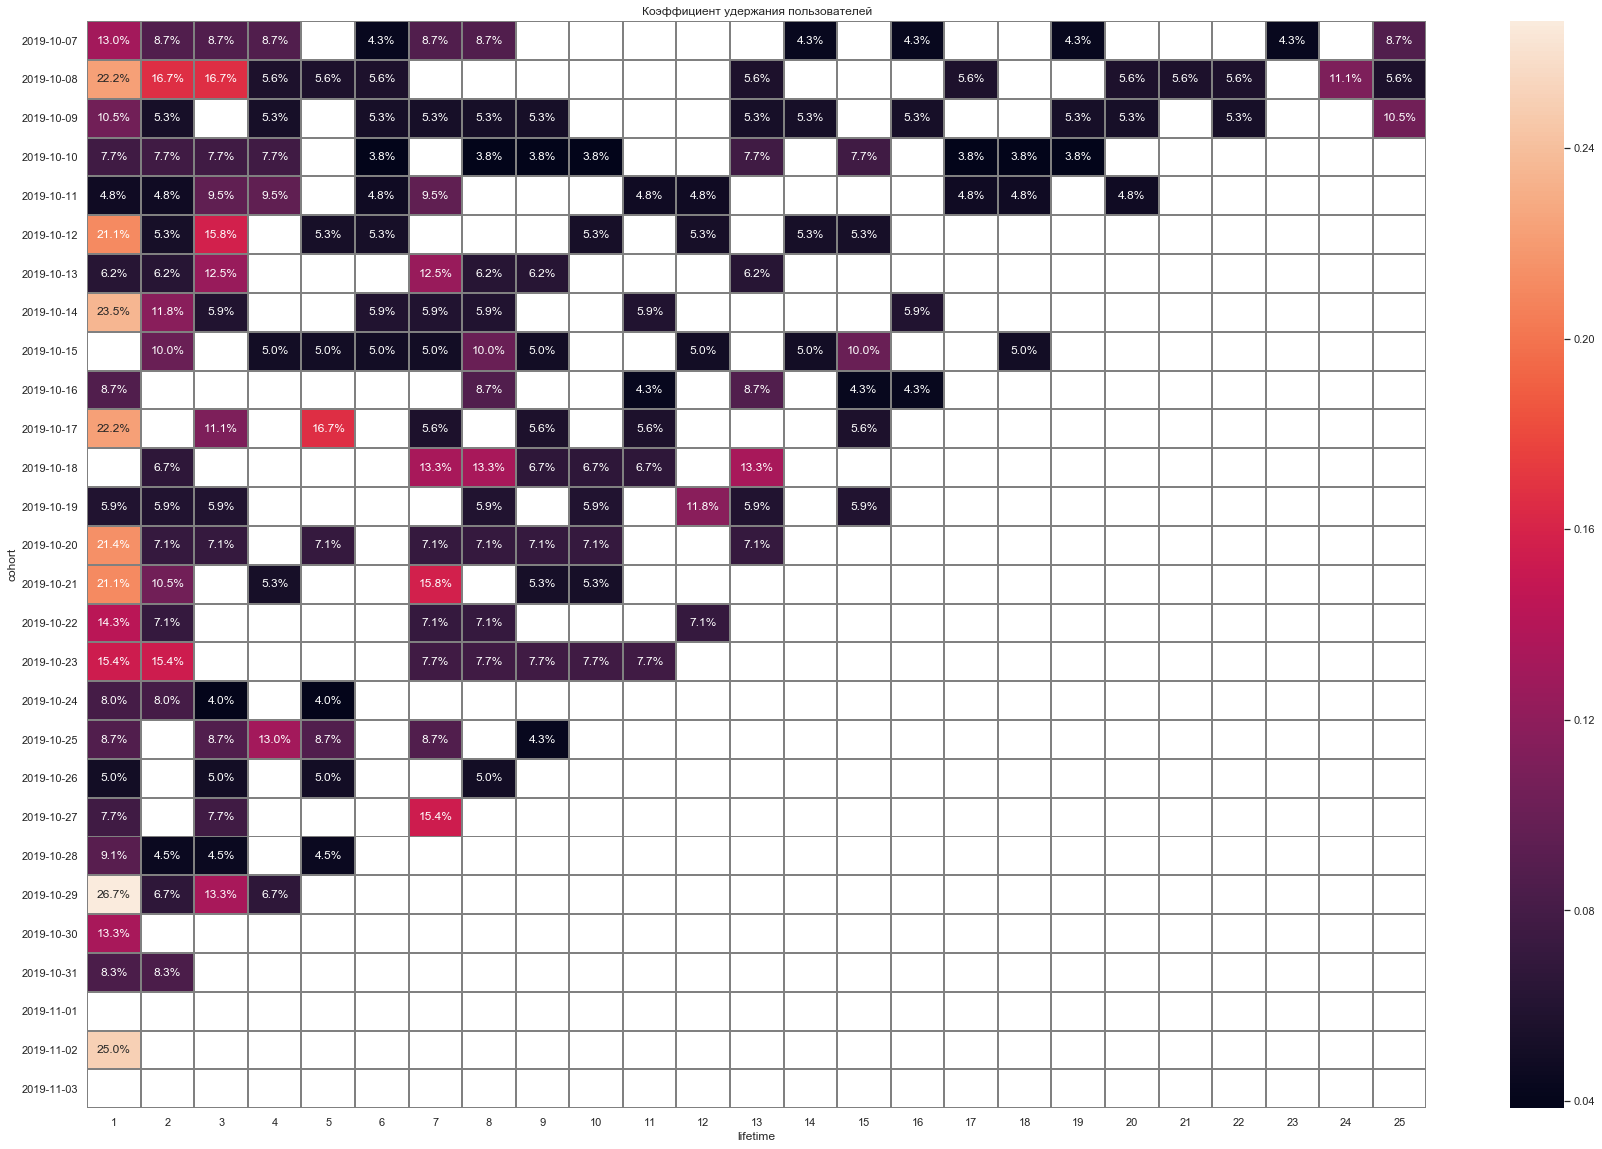

In [45]:
show_retention(cluster_0)

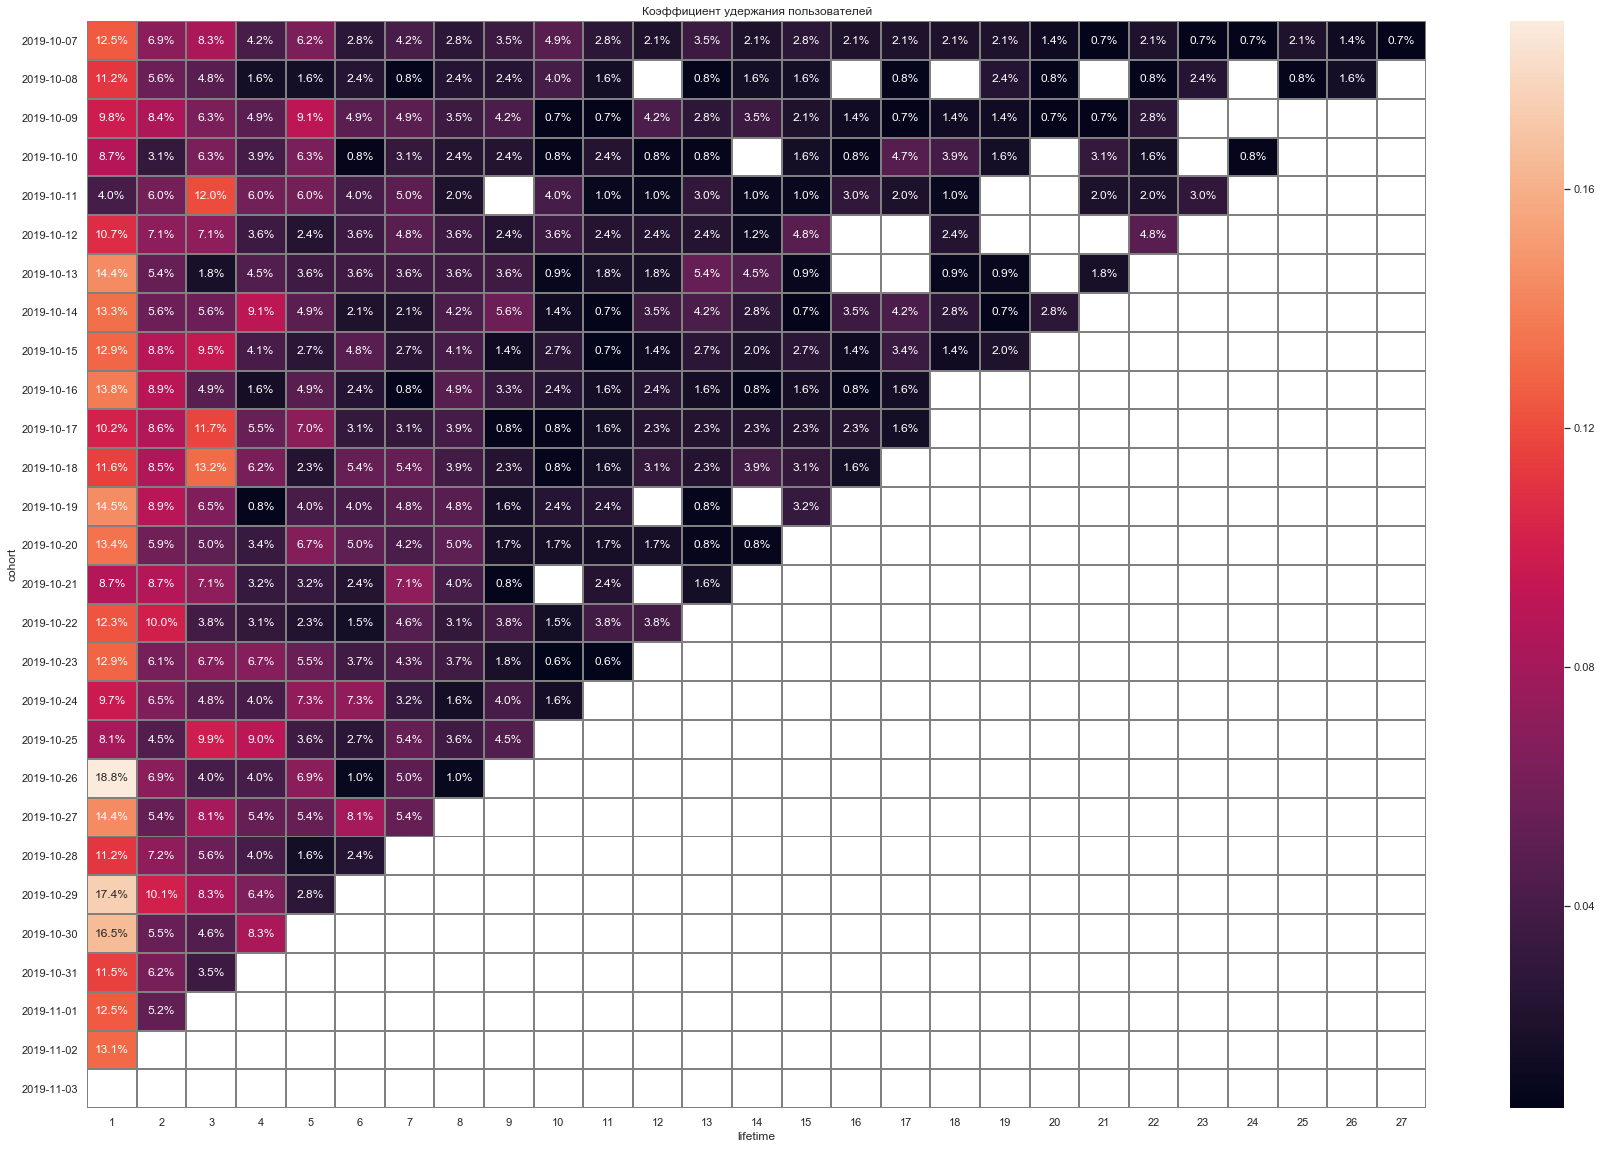

In [46]:
show_retention(cluster_1)

Таблицы получаются фрагментарными, особенно для меньшего из двух кластеров, но отчетливо видно, что у более активного кластера retention rate выше.

**Проверка гипотез**

В разделе про продуктовую воронку мы обнаружили незначительные отличия в конверсии у пользователей, которые приходят в приложение из двух крупных поисковиков -- Yandex и Google. Проверим, значимо ли это различие с точки зрения статистики. Поскольку речь идет о сравнении пропорций, используем z-критерий.

Нулевая гипотеза: Различий в конверсии в просмотры контактов между пользователями, пришедшими из Google и из Yandex, нет. Альтернативная гипотеза: различия есть.

In [47]:
def check_props(df, col, compare_list, alpha):
    alpha = alpha
    distr = st.norm(0, 1)
    group_one = df.loc[df[col].astype('str').str.contains(compare_list[0])]
    group_two = df.loc[df[col].astype('str').str.contains(compare_list[1])]
    success_one = group_one.query('event_name == "contacts_show"').user_id.nunique()
    success_two = group_two.query('event_name == "contacts_show"').user_id.nunique()
    trials_one = group_one.user_id.nunique()
    trials_two = group_two.user_id.nunique()
    p1 = success_one/trials_one
    p2 = success_two/trials_two
    p_combined = (success_one + success_two)/(trials_one + trials_two)
    difference = p1 - p2
    z_value = difference/\
    mth.sqrt(p_combined*(1 - p_combined)*(1/group_one.user_id.nunique() + 1/group_two.user_id.nunique()))
    p_value = (1 - distr.cdf(abs(z_value))) * 2 # умножение на два, так как имеем дело с двухсторонней гипотезой
    print('Доля успехов в группе {} равна {}'.format(compare_list[0], p1))
    print('Доля успехов в группе {} равна {}'.format(compare_list[1], p2))
    print('P-value равен {}'.format(p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    return None

In [48]:
check_props(df, 'source', ['google', 'yandex'], 0.05)

Доля успехов в группе google равна 0.24357838795394154
Доля успехов в группе yandex равна 0.24715615305067218
P-value равен 0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Выше мы выяснили, что те пользователи, которые пользуются поиском типа `search_1` (и только им одним), показывают более высокую конверсию, чем те, кто не пользуюся поиском вообще или применяет другие поисковые инструменты. Проверим, есть ли статистически значимая разница между этими двумя группами.

In [49]:
search_or_not = df.merge(freqs_ultimate[['user_id', 'search_pattern']],
                         how='left', left_on='user_id', right_on='user_id')
check_props(search_or_not, 'search_pattern', ['search_1', '^((?!search_1).)*$'], 0.05)

Доля успехов в группе search_1 равна 0.301143583227446
Доля успехов в группе ^((?!search_1).)*$ равна 0.21220764403879064
P-value равен 7.875225316311685e-08
Отвергаем нулевую гипотезу: между долями есть значимая разница


c:\users\1\appdata\local\programs\python\python38\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


### Выводы

Сначала приведем некоторые данные об аудитории приложения:

* Приложением пользуются в среднем около 280 пользователей в день и 1380 в неделю.
* Медианные значения количества действий в приложении на пользователя: 0,77 в день и 5,4 в неделю.
* Медианная длительность сессии в приложении: 1 минута 51 секунда. 
* Обычно пользователи заходят в приложение дважды за день и каждый раз совершают около 4 действий (медианные значения).
* Поисковые функции в приложении используют чуть менее 38% уникальных пользователей.

Изучение корреляций между частотой различных действий в приложении показало сильную связь между открытием карты размещенных объявлений и открытием карточек объявлений. Это значит, что если в будущем окажется, что бизнес заинтересован в увеличении количества открываемых объявлений, на этот показатель, скорее всего, можно будет повлиять, работая с этой картой. Впрочем, утверждать, что тут есть причинно-следственная связь без дополнительных исследований нельзя.

Кроме того, показ контактов коррелирует с кликами по рекомендованным объявлениям и с одним из поисковых действий -- search_7.

Примечательно, что при расчете конверсии на первом месте среди всех возможных поисковых стратегий, включая полное не-использование поисковых действий, оказывается другой вид поиска -- search_1 (почти 30%). При этом он, во-первых, редко сочетается с другими видами поиска и, во-вторых, не показал корреляции с `contacts_show` при расчете коэффициентов Пирсона. Те, кто поиском в приложении не пользовались вообще, по конверсии немного отстают (~23%).

Разбиение на кластеры при помощи моделей машинного обучения дает два кластера неравного размера, причем если данные очистить от выбросов по количеству действий на пользователя, эта разница становится значительно меньше. 

Алгоритм K-Means выделяет в меньший из двух кластеров самых активных пользователей. Однако некоторые параметры у них не выше, а, наоборот, ниже, чем у основной массы: они в среднем смотрят меньше фотографий, чем основная масса пользователей, и у них как правило короче сессия. 

Это, в частности, означает, что стремиться к увеличению продолжительности сессий не нужно, лучше наращивать их количество. Кроме того, более активные пользователи никогда не звонят по номеру телефона в объявлении из приложения, только смотрят этот номер -- возможно, это означает, что они в основном пользуются приложением на такой платформе, которая не дает возможности совершать звонки (например, десктоп или планшет).

Разница между двумя кластерами видна и в retention rate: у более активных пользователей он выше.

Результаты проверки гипотез следующие: 

Между пользователями, пришедшими в приложение из Google и Yandex, отсутствуют различия в конверсии. Можно рекомендовать привлекать трафик из этих двух каналов в равных пропорциях.

Различия в конверсии есть между теми, кто из всех доступных поисковых действий применяет search_1, и всеми остальными пользователями. Вкупе с результатами расчета конверсии и корреляции между параметрами это говорит о том, что если в интерфейс приложения будут вноситься изменения, лучше отдать приоритет поисковым инструментам search_1 и search_7 (либо иным образом стимулировать их использование).

**Некоторые из использованных источников**

Выбор статистического критерия для A/B теста https://lit-review.ru/biostatistika/vybor-statisticheskogo-kriteriya/
Автор рассказывает, как выбрать критерий для A/B теста в зависимости от типа исследуемых данных и их распределения.

Корреляция и коэффициент корреляции https://tocodata.com/marketing/korrelyaciya.html
Краткая справка о том, как правильно рассчитывать и интерпретировать коэффициенты корреляции.

Обучение без учителя: 4 метода кластеризации данных на Python https://proglib.io/p/unsupervised-ml-with-python
Понятная объяснялка про методы кластеризации, в частности про k-means и иерархическую кластеризацию, использованные в этом исследовании.

Как выделить сессии из логов http://datalytics.ru/all/delaem-sessii-iz-loga-sobytiy-s-pomoschyu-pandas/
В статье предложен способ выделения пользовательских сессий на основе сырых логов, похожий на тот, который был использован в этом исследовании.

Статистичсекие гипотезы http://mathhelpplanet.com/static.php?p=statisticheskie-gipotezy
Мануал по статистическим гипотезам, с разъяснением про ошибки первого и второго рода.




